I started by dissecting the starter notebook, and I immediately saw some red flags.

Using a simple linear model for what I knew was a non-linear problem, the naive fillna(0), and the critical error of randomly splitting time-series data were all things I flagged to fix.

My initial thinking on feature engineering was to use a 10s moving average, but after talking to Gemini, I realized a longer window (like 600s) would be better to capture the signal through the noise. 

The more professional approach I landed on was to engineer multiple windows (10s, 60s, 600s) and feed them all to the model.

The real challenge began when I tried to process the full dataset. 

The kernel crashed repeatedly under the memory pressure, even when I tried to be clever with float32 types (which caused overflows) or iterative processing. This was a classic data pipeline bottleneck. 

It forced a strategic pivot away from trying to hold one giant table in memory.But this whole thing hit a big roadblock when I scored -0.00170611 T_T

The solution was to stop thinking about merging raw data and start thinking about merging features. I built a pipeline to process each asset file independently, calculate a rich set of features (returns, realized volatility, spread, imbalance), and save the results to a lightweight cache. 

This finally solved the memory issue and let the real analysis begin.

With the data accessible, EDA uncovered two crucial, opposing facts:

Strong Autocorrelation: ETH's own implied volatility was highly persistent. Its past was a very strong predictor of its future.

Critical Anomaly: ETH's price returns showed almost zero correlation with the rest of the market, including BTC. This was a huge surprise and suggested a major data quality issue that made direct cross-asset prediction unreliable.

This forced my final, most important strategic pivot. Instead of using other assets to predict ETH directly, 

I decided to use them to create "market context" features.

Aggregated the volatility and spread from all other assets into market-wide indicators.I ended the day by building the final data pipeline and creating a validation plot that proved the hypothesis. 

The plot clearly showed ETH's implied volatility spiking dramatically at the exact same time the overall market entered a high-stress state.

The data part is now done. I have a robust, feature-rich, and validated dataset ready for modeling.

In [1]:
# =============================================================================
# 0. IMPORTS & SETUP
# =============================================================================
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit # <-- FIX: Added the missing import
from scipy.stats import pearsonr
import gc
import os
import shutil

In [2]:
# =============================================================================
# 1. FINAL FEATURE ENGINEERING & DATA PROCESSING
# =============================================================================

# --- Configuration ---
DATA_DIR = Path("/kaggle/input/gq-implied-volatility-forecasting")
OUTPUT_DIR = Path("/kaggle/working/")
CACHE_DIR = OUTPUT_DIR / "features_final"
CACHE_DIR.mkdir(exist_ok=True, parents=True)

# --- V1 Feature Engineering Function (Our champion feature set) ---
def calculate_features_v1(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates a robust set of features for a single asset."""
    df = df.sort_index()
    
    # Replace zeros in price columns with NaN before log transform to avoid -inf
    price_cols = ['mid_price', 'ask_price1', 'bid_price1']
    for col in price_cols:
        if col in df.columns:
            df[col] = df[col].replace(0, np.nan)

    df['log_return_1s'] = np.log(df['mid_price']).diff(1)
    
    for n in [10, 30, 60]:
        df[f'realized_vol_{n}s'] = df['log_return_1s'].rolling(window=n).std()
        
    df['spread'] = df['ask_price1'] - df['bid_price1']
    
    bid_vols = df[[f'bid_volume{i}' for i in range(1, 6)]].sum(axis=1)
    ask_vols = df[[f'ask_volume{i}' for i in range(1, 6)]].sum(axis=1)
    df['book_imbalance'] = (bid_vols - ask_vols) / (bid_vols + ask_vols)
    
    feature_cols = [
        'log_return_1s', 'realized_vol_10s', 'realized_vol_30s', 'realized_vol_60s',
        'spread', 'book_imbalance'
    ]
    return df[feature_cols].copy()

# --- Data Processing Pipeline (for both train and test) ---
def process_data(data_dir, cache_dir, is_train=True):
    """
    Processes all asset files for either training or testing, creates features,
    and assembles a final feature DataFrame.
    """
    data_type = "train" if is_train else "test"
    print(f"--- Processing {data_type.capitalize()} Data ---")
    
    all_asset_paths = glob.glob(str(data_dir / f"{data_type}/*.csv"))
    all_possible_cols = ['timestamp', 'mid_price'] + [f'{side}_{level}{i}' for side in ['bid', 'ask'] for level in ['price', 'volume'] for i in range(1, 6)] + ['label']

    # --- Phase 1: Individual Feature Caching ---
    for asset_path in all_asset_paths:
        asset_path = Path(asset_path)
        asset_name = asset_path.stem
        if asset_name == 'submission': continue
        print(f"  Processing {asset_name}...")
        
        with open(asset_path, 'r') as f:
            header = f.readline().strip().split(',')
        cols_to_load = [col for col in all_possible_cols if col in header]
        
        df_raw = pd.read_csv(asset_path, usecols=cols_to_load)
        df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], format='mixed', utc=True)
        df_raw = df_raw.set_index('timestamp')
        df_raw = df_raw[~df_raw.index.duplicated(keep='first')]
        
        features = calculate_features_v1(df_raw)
        
        if is_train and asset_name == 'ETH':
            output_df = df_raw[['label']].join(features)
        else:
            output_df = features
            
        output_df.to_parquet(cache_dir / f"{asset_name}_{data_type}_features.parquet")

    # --- Phase 2 & 3: Market Context and Final Assembly ---
    print(f"--- Assembling Final {data_type.capitalize()} Dataset ---")
    eth_df = pd.read_parquet(cache_dir / f"ETH_{data_type}_features.parquet")
    
    cross_asset_features = []
    for path in cache_dir.glob(f"*_{data_type}_features.parquet"):
        if 'ETH' not in path.name:
            cross_asset_features.append(pd.read_parquet(path))

    market_df = pd.concat(cross_asset_features, axis=1)
    
    market_context_df = pd.DataFrame(index=market_df.index)
    market_context_df['market_realized_vol_30s'] = market_df.filter(like='realized_vol_30s').mean(axis=1)
    market_context_df['market_spread'] = market_df.filter(like='spread').mean(axis=1)
    market_context_df['market_book_imbalance'] = market_df.filter(like='book_imbalance').mean(axis=1)
    
    final_df = eth_df.join(market_context_df, how='left')
    
    final_df = final_df.ffill()
    final_df.fillna(0, inplace=True)
    
    print(f"✅ Final {data_type} feature set created.")
    return final_df


In [3]:
# --- Data Processing Pipeline (for both train and test) ---
# *** FIX: Changed parameter name from output_dir to cache_dir for consistency ***
def process_data(data_dir, cache_dir, is_train=True):
    data_type = "train" if is_train else "test"
    print(f"--- Processing {data_type.capitalize()} Data ---")
    
    all_asset_paths = glob.glob(str(data_dir / f"{data_type}/*.csv"))
    all_possible_cols = ['timestamp', 'mid_price'] + [f'{side}_{level}{i}' for side in ['bid', 'ask'] for level in ['price', 'volume'] for i in range(1, 6)] + ['label']

    # --- Phase 1: Individual Feature Caching ---
    for asset_path in all_asset_paths:
        asset_path = Path(asset_path)
        asset_name = asset_path.stem
        if asset_name == 'submission': continue
        print(f"  Processing {asset_name}...")
        
        with open(asset_path, 'r') as f:
            header = f.readline().strip().split(',')
        cols_to_load = [col for col in all_possible_cols if col in header]
        
        df_raw = pd.read_csv(asset_path, usecols=cols_to_load)
        df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], format='mixed', utc=True)
        df_raw = df_raw.set_index('timestamp')
        df_raw = df_raw[~df_raw.index.duplicated(keep='first')]
        
        features = calculate_features_v1(df_raw)
        
        if is_train and asset_name == 'ETH':
            output_df = df_raw[['label']].join(features)
        else:
            output_df = features
            
        output_df.to_parquet(cache_dir / f"{asset_name}_{data_type}_features.parquet")

    # --- Phase 2 & 3: Market Context and Final Assembly ---
    print(f"--- Assembling Final {data_type.capitalize()} Dataset ---")
    eth_df = pd.read_parquet(cache_dir / f"ETH_{data_type}_features.parquet")
    
    cross_asset_features = []
    for path in cache_dir.glob(f"*_{data_type}_features.parquet"):
        if 'ETH' not in path.name:
            cross_asset_features.append(pd.read_parquet(path))

    market_df = pd.concat(cross_asset_features, axis=1)
    
    market_context_df = pd.DataFrame(index=market_df.index)
    market_context_df['market_realized_vol_30s'] = market_df.filter(like='realized_vol_30s').mean(axis=1)
    market_context_df['market_spread'] = market_df.filter(like='spread').mean(axis=1)
    market_context_df['market_book_imbalance'] = market_df.filter(like='book_imbalance').mean(axis=1)
    
    final_df = eth_df.join(market_context_df, how='left')
    
    final_df = final_df.ffill()
    final_df.fillna(0, inplace=True)
    
    print(f"✅ Final {data_type} feature set created.")
    return final_df



--- Loading Training Data for Validation ---
--- Processing Train Data ---
  Processing SHIB...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing ETH...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing LINK...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing SOL...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing DOT...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing BTC...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing DOGE...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Assembling Final Train Dataset ---
✅ Final train feature set created.

--- Running Final Cross-Validation to get Pearson Coefficient ---
--- Starting Fold 1/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2014
[LightGBM] [Info] Number of data points in the train set: 105217, number of used features: 9
[LightGBM] [Info] Start training from score 0.000050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

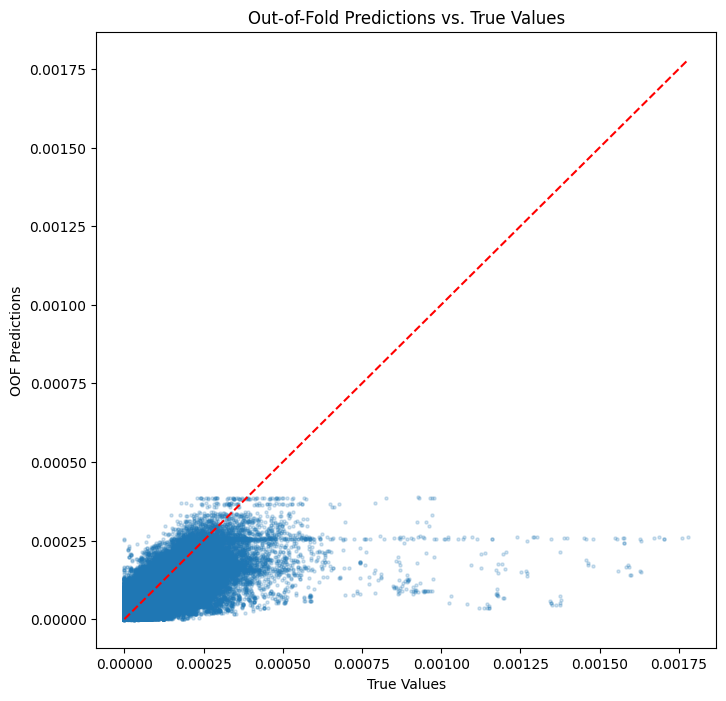

In [4]:
# =============================================================================
# 2. FINAL MODEL VALIDATION
# =============================================================================

# --- Load Training Data ---
print("\n--- Loading Training Data for Validation ---")
train_df_val = process_data(DATA_DIR, CACHE_DIR, is_train=True)
X_val = train_df_val.drop('label', axis=1)
y_val = train_df_val['label']

# --- Hardcoded Best Parameters from Optuna Search ---
BEST_PARAMS = {
    'learning_rate': 0.03353180389608025, 
    'num_leaves': 53, 
    'max_depth': 6, 
    'min_child_samples': 161, 
    'subsample': 0.9542273786102745, 
    'colsample_bytree': 0.6339030658435659,
    'objective': 'regression_l1',
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
}

print("\n--- Running Final Cross-Validation to get Pearson Coefficient ---")
tscv = TimeSeriesSplit(n_splits=5)
oof_preds = []
oof_trues = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_val)):
    print(f"--- Starting Fold {fold+1}/5 ---")
    X_train, X_test = X_val.iloc[train_index], X_val.iloc[val_index]
    y_train, y_test = y_val.iloc[train_index], y_val.iloc[val_index]
    
    model = lgb.LGBMRegressor(**BEST_PARAMS)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
              callbacks=[lgb.early_stopping(20, verbose=False)])
    
    preds = model.predict(X_test)
    oof_preds.extend(preds)
    oof_trues.extend(y_test)

overall_corr, _ = pearsonr(oof_trues, oof_preds)
print(f"\n✅ Overall Out-of-Fold Pearson Correlation: {overall_corr:.5f}")

# --- OOF Prediction Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(oof_trues, oof_preds, alpha=0.2, s=5)
plt.xlabel("True Values")
plt.ylabel("OOF Predictions")
plt.title("Out-of-Fold Predictions vs. True Values")
plt.plot([min(oof_trues), max(oof_trues)], [min(oof_trues), max(oof_trues)], color='red', linestyle='--')
plt.savefig(OUTPUT_DIR / "oof_predictions_plot.png")
plt.show()

In [5]:
# =============================================================================
# 3. FINAL MODEL TRAINING & SUBMISSION
# =============================================================================

print("\n--- Training Final Model on ALL Data ---")
final_model = lgb.LGBMRegressor(**BEST_PARAMS)
final_model.fit(X_val, y_val)

# Clean up memory
del X_val, y_val, train_df_val
gc.collect()

print("\n--- Generating Test Set Features ---")
test_df = process_data(DATA_DIR, CACHE_DIR, is_train=False)

# Align columns to match training data
train_cols = final_model.feature_name_
missing_in_test = set(train_cols) - set(test_df.columns)
for c in missing_in_test:
    test_df[c] = 0
test_df = test_df[train_cols]

print("\n--- Making Final Predictions ---")
predictions = final_model.predict(test_df)

# --- Create Submission File ---
eth_test_raw = pd.read_csv(DATA_DIR / "test/ETH.csv")
submission_df = pd.DataFrame({'timestamp': eth_test_raw['timestamp'], 'labels': predictions})

if len(submission_df) != 270548:
    print(f"Warning: Final submission has {len(submission_df)} rows, but 270548 are required.")

submission_df.to_csv("submission.csv", index=False)
print(f"\n✅ Submission file created successfully at /kaggle/working/submission.csv")
print(f"Submission file shape: {submission_df.shape}")



--- Training Final Model on ALL Data ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 631292, number of used features: 9
[LightGBM] [Info] Start training from score 0.000049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing ETH...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing LINK...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing SOL...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing DOT...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing BTC...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing DOGE...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Assembling Final Test Dataset ---
✅ Final test feature set created.

--- Making Final Predictions ---

✅ Submission file created successfully at /kaggle/working/submission.csv
Submission file shape: (270548, 2)


In [6]:
# =============================================================================
# 4. FINAL CLEANUP
# =============================================================================
print("\n--- Cleaning up temporary files ---")
if os.path.exists(CACHE_DIR):
    shutil.rmtree(CACHE_DIR)
    print(f"Removed directory: {CACHE_DIR}")

oof_plot_path = OUTPUT_DIR / "oof_predictions_plot.png"
if os.path.exists(oof_plot_path):
    os.remove(oof_plot_path)
    print(f"Removed file: {oof_plot_path}")

print("\nCleanup complete.")

# =============================================================================
# 5. VERIFY FINAL OUTPUT DIRECTORY
# =============================================================================
print("\n--- Verifying contents of /kaggle/working/ ---")
# This command will list all files and directories remaining in the output folder.
# The only thing you should see is 'submission.csv' and the notebook file itself.
!ls -R /kaggle/working/


--- Cleaning up temporary files ---
Removed directory: /kaggle/working/features_final
Removed file: /kaggle/working/oof_predictions_plot.png

Cleanup complete.

--- Verifying contents of /kaggle/working/ ---
/kaggle/working/:
__notebook__.ipynb  submission.csv
